<a href="https://colab.research.google.com/github/JacksonHassell/SchoolProjects/blob/main/RiverRaid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/code/franckepeixoto/reinforcement-learning-river-raid-atari/notebook

https://github.com/tensorflow/agents#Tutorials

In [ ]:
import numpy as np
import gym
import tensorflow as tf
import time
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, Input
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!python -m atari_py.import_roms /content/drive/MyDrive/Roms_Opt

copying assault.bin from HC ROMS/NTSC VERSIONS OF PAL ORIGINALS/Assault (AKA Sky Alien) (1983) (Bomb - Onbase) (CA281).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/assault.bin
copying pacman.bin from HC ROMS/PAL VERSIONS OF NTSC ORIGINALS/Pac-Man (1982) (Atari, Tod Frye) (CX2646) (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/pacman.bin
copying keystone_kapers.bin from HC ROMS/PAL VERSIONS OF NTSC ORIGINALS/Keystone Kapers - Raueber und Gendarm (1983) (Activision, Garry Kitchen - Ariola) (EAX-025, EAX-025-04I - 711 025-725) (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/keystone_kapers.bin
copying king_kong.bin from HC ROMS/PAL VERSIONS OF NTSC ORIGINALS/King Kong (1982) (Tigervision - Software Electronics Corporation, Karl T. Olinger - Teldec) (7-001 - 3.60001 VE) (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/king_kong.bin
copying mr_do.bin from HC ROMS/PAL VERSIONS OF NTSC ORIGINALS/Mr. D

In [ ]:
env = gym.make("RiverraidNoFrameskip-v4")

In [ ]:
env.unwrapped.get_action_meanings()

# Right, left, fire actually mean that
# The first 80 frames of each game are useless
# You have to take an action besides no-op at frame 80 to start the game

['NOOP',
 'FIRE',
 'UP',
 'RIGHT',
 'LEFT',
 'DOWN',
 'UPRIGHT',
 'UPLEFT',
 'DOWNRIGHT',
 'DOWNLEFT',
 'UPFIRE',
 'RIGHTFIRE',
 'LEFTFIRE',
 'DOWNFIRE',
 'UPRIGHTFIRE',
 'UPLEFTFIRE',
 'DOWNRIGHTFIRE',
 'DOWNLEFTFIRE']

In [ ]:
raw_pixels = env.reset()
raw_pixels.shape

(210, 160, 3)

In [ ]:
from PIL import Image

def prepro(I):
    I = I[:, 40:115] #Remove extra space to the left and right
    I = I[:160,:] #Remove UI elements from bottom

    #Convert to greyscale
    I = np.array(Image.fromarray(I).convert('L'))

    return np.array(I.copy())

In [ ]:
def discount_rewards(env_rewards):
  res = [0]
  discount = .99
  for i in reversed(range(len(env_rewards))):
    res = [env_rewards[i] + res[0] * discount] + res
  return res[:-1]

In [ ]:
def create_model(height,width,channels):
    # we cannot simply have 3 output nodes because we want to put a weight on each node's impact to the objective
    # that is different for each data point.  the only way to achieve this is to have 3 output layers, each having 1 node
    # the effect is the same, just the way TF/keras handles weights is different
    imp = Input(shape=(height,width,channels))
    mid = Conv2D(16,(8,8),strides=4,activation='relu')(imp)
    mid = Conv2D(32,(4,4),strides=2,activation='relu')(mid)
    mid = Flatten()(mid)
    mid = Dense(256,activation='relu')(mid)
    out0 = Dense(4,activation='softmax')(mid)
    model = Model(imp,out0)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),loss='sparse_categorical_crossentropy')

    return model

In [ ]:
frames_to_net = 4              # how many previous frames will we feed the NN
possible_actions = [0,1,3,4]
mod = create_model(160,85,frames_to_net)
mod.call = tf.function(mod.call,experimental_relax_shapes=True)

In [ ]:
mod.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 85, 4)]      0         
                                                                 
 conv2d (Conv2D)             (None, 39, 20, 16)        4112      
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 9, 32)         8224      
                                                                 
 flatten (Flatten)           (None, 5184)              0         
                                                                 
 dense (Dense)               (None, 256)               1327360   
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 1,340,724
Trainable params: 1,340,724
Non-train

In [ ]:
def play1game(model):
    env0 = gym.make("RiverraidNoFrameskip-v4")
    env0.seed(1)
    pix = env0.reset()
    pix = prepro(pix)
    frames_this_game = 0
    feed = np.zeros((1,160,75,frames_to_net))
    feed[0,:,:,0] = pix.copy()


    frame_array = []
    action_array = []
    reward_array = []

    score = 0
    done = False
    fcount = 0
    i = 0
    while not done:
        if i < 80:
          action = 0
        elif i == 80:
          action = 1
        else:
          if fcount == 0:
              vf = model(feed,training=False).numpy()[0]
              action = np.random.choice(len(vf),p=vf)
              fcount += 1
          elif fcount == (frames_to_net - 1):
              fcount = 0
          else:
              fcount += 1

          action0 = possible_actions[action]
          pix_new, reward, done, info = env0.step(action0)
          frame_array.append(pix)
          action_array.append(action)
          reward_array.append(reward)
          pix = prepro(pix_new)
          frames_this_game += 1

          for f in range(1,frames_to_net):
              feed[0,:,:,frames_to_net-f] = feed[0,:,:,frames_to_net-f-1].copy()
          feed[0,:,:,0] = pix.copy()
          score += reward

          if i == 100000:
            break;
        i += 1

    return frame_array, action_array, reward_array, score

In [ ]:
mod = create_model(160,75,frames_to_net)
mod.call = tf.function(mod.call,experimental_relax_shapes=True)

In [ ]:
ngames = 5000
nbatch = 10
buffn = 200000
warmupgames = 50
len_buff = 0
buffer = {'frames':[],'actions':[],'rewards':[]}

tf.random.set_seed(1)
np.random.seed(1)

scores = np.ndarray((ngames))

for game in range(ngames):
    start = time.time()
    frames, actions, rewards, score = play1game(mod)
    rewards = discount_rewards(rewards.copy())
    buffer['frames'] += frames.copy()
    buffer['actions'] += actions.copy()
    buffer['rewards'] += rewards.copy()
    len_buff += len(actions)
    if len_buff > buffn:
        excess = len_buff - buffn
        buffer['frames'] = buffer['frames'][excess:].copy()
        buffer['actions'] = buffer['actions'][excess:].copy()
        buffer['rewards'] = buffer['rewards'][excess:].copy()
        len_buff = len(buffer['actions'])
    rewards = np.array(rewards)
    actions = np.array(actions)
    nframes = len(frames)
    current_frames = np.zeros((nframes,160,75,frames_to_net))



    if game >= warmupgames:
        prob = np.ones(len_buff)
        prob[np.array(buffer['rewards']) > 0] = 5.0
        prob /= np.sum(prob)
        which_choose = np.random.choice(len_buff,size=nframes,replace=False,p=prob)

        for grab in range(nframes):
            rewards[grab] = buffer['rewards'][which_choose[grab]]
            actions[grab] = buffer['actions'][which_choose[grab]]
            for f in range(frames_to_net):
                if grab-f > 0:
                    current_frames[grab,:,:,f] = buffer['frames'][which_choose[grab]-f].copy()

        mod.fit(current_frames,actions,epochs=1,steps_per_epoch=nbatch,verbose=0,sample_weight=rewards,use_multiprocessing=True)
    stop = time.time()
    print(game, score, round(stop-start),len_buff)
    scores[game] = score

print(scores[-100:].mean())

Streaming output truncated to the last 5000 lines.
1 0.0 1 1650
2 0.0 1 2475
3 0.0 1 3300
4 0.0 1 4125
5 0.0 1 4950
6 30.0 1 5789
7 0.0 1 6614
8 0.0 1 7439
9 0.0 1 8264
10 0.0 1 9089
11 0.0 1 9914
12 0.0 1 10739
13 0.0 1 11564
14 0.0 1 12389
15 0.0 1 13214
16 0.0 1 14039
17 0.0 1 14864
18 0.0 1 15689
19 0.0 1 16514
20 0.0 1 17339
21 0.0 1 18164
22 0.0 1 18989
23 0.0 1 19814
24 0.0 1 20639
25 0.0 1 21464
26 0.0 1 22289
27 0.0 1 23114
28 0.0 1 23939
29 0.0 1 24764
30 0.0 2 25589
31 0.0 2 26414
32 0.0 2 27239
33 0.0 2 28064
34 0.0 2 28889
35 0.0 2 29714
36 0.0 2 30539
37 0.0 2 31364
38 0.0 2 32189
39 0.0 2 33014
40 0.0 2 33839
41 0.0 2 34664
42 0.0 1 35489
43 30.0 2 36328
44 0.0 2 37153
45 0.0 2 37978
46 0.0 1 38803
47 0.0 2 39628
48 0.0 2 40453
49 0.0 1 41278
50 0.0 3 42103
51 0.0 2 42928
52 0.0 2 43753
53 0.0 2 44578
54 0.0 2 45403
55 0.0 2 46228
56 0.0 2 47053
57 0.0 2 47878
58 0.0 2 48703
59 0.0 2 49528
60 0.0 2 50353
61 30.0 2 51192
62 0.0 2 52017
63 30.0 2 52856
64 0.0 2 53681
65 30

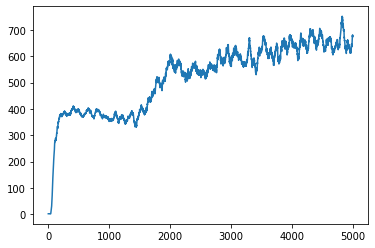

In [ ]:
from scipy.ndimage.filters import uniform_filter1d
data = uniform_filter1d(scores, size=50)
sns.lineplot(x=range(len(data)), y=data) # Running mean score of the last 50 games

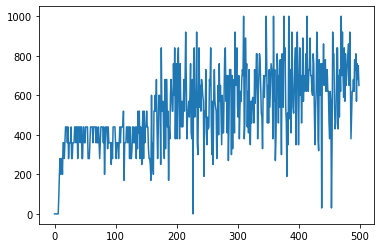

In [ ]:
data = scores[::10]
sns.lineplot(x=range(len(data)), y=data) # Every tenth score